# Training 

This notebook includes an example training loop for a one stage model.

In [2]:
import torch
import os
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

from model.one_model.one_stage_models import ResNet50OneStage, ResNet18OneStage
from data.dataset import CheXpertDataset

In [3]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots


os.environ['KMP_DUPLICATE_LIB_OK']='True' # To prevent the kernel from dying.

## Datasets

In [ ]:
# Define parameter dictionary
params_transform = {
    "resize": (256, 256),
    "degree_range": (-15, 15),
    "translate": (0.1, 0.2),
    "scale": (0.2, 1.0),
    "ratio": (0.75, 1.3333333333333333),
    "gaussian_blur_kernel": 3,
    "contrast": (0.75, 1.25),
    "saturation": (0.75, 1.25),
    "brightness": (0.75, 1.25),
}

transform = transforms.Compose(
    [
        transforms.Resize(params_transform["resize"]),
        transforms.ToTensor(),
        transforms.RandomRotation(params_transform["degree_range"]),
        transforms.RandomAffine(
            degrees=params_transform["degree_range"],
            translate=params_transform["translate"],
        ),
        transforms.RandomResizedCrop(
            size=params_transform["resize"],
            scale=params_transform["scale"],
            ratio=params_transform["ratio"],
        ),
        transforms.GaussianBlur(kernel_size=params_transform["gaussian_blur_kernel"]),
        transforms.ColorJitter(
            brightness=params_transform["brightness"],
            contrast=params_transform["contrast"],
            saturation=params_transform["saturation"],
        ),
    ]
)

val_transform = transforms.Compose(
    [
        transforms.Resize(params_transform["resize"]),
        transforms.ToTensor(),
    ]
)

targets = {
    # "sex": 1,
    # "age": 2,
    # "frontal/lateral": 3,
    # "ap/pa": 4,
    # "no_finding": 5,
    # "enlarged_cardiomediastinum": 6,
    # "cardiomegaly": 7,
    # "lung_opacity": 8,
    # "lung_lesion": 9,
    # "edema": 10,
    # "consolidation": 11,
    # "pneumonia": 12,
    # "atelectasis": 13,
    # "pneumothorax": 14,
    # "pleural_effusion": 15,
    # "pleural_other": 16,
    # "fracture": 17,
    # "support_devices": 18,
    "ap/pa map": 22,
}

train_dataset = CheXpertDataset(
    csv_file="./data/valid.csv",
    root_dir="../image_data/",
    targets=targets,
    transform=transform,
)
val_dataset = CheXpertDataset(
    csv_file="./data/valid.csv",
    root_dir="../image_data/",
    targets=targets,
    transform=val_transform,
)

Labels found: [0 1]
Labels found: [0 1]


Train dataset size: 202
Valid dataset size: 202
Example
labels: [0.]
torch.Size([1, 256, 256])


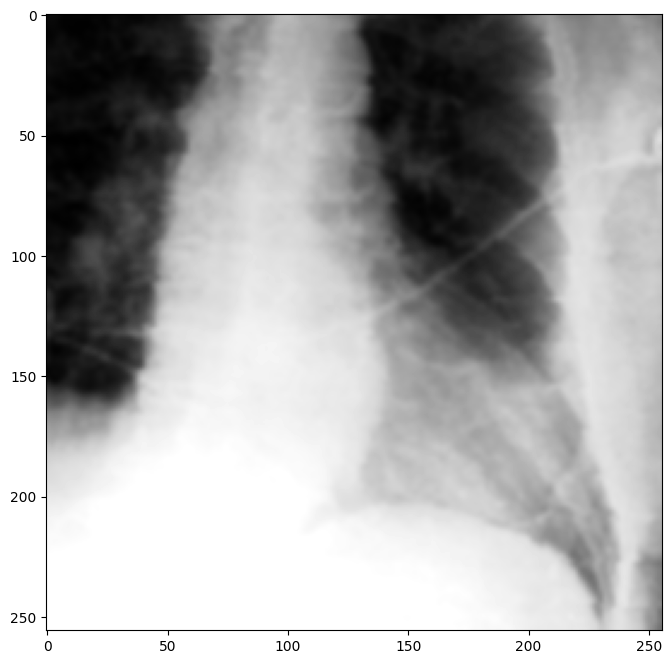

In [9]:
print(f"Train dataset size: {len(train_dataset)}")
print(f"Valid dataset size: {len(val_dataset)}")

print("Example")
img, labels = train_dataset[0]
print(f"labels: {labels}")
print(f"{img.shape}")
img = img.squeeze().numpy()
plt.imshow(img, cmap='gray')

## Define model

In [ ]:
params = {
    "train_transfrom": params_transform,
    "lr": 0.001,
    "save_epoch": 5,
    "batch_size": 32,
    "num_epochs": 10,
    "num_labels": 1,
    "input_channels": 1,
    "optimizer": "adam",
    # BCE with Sigmoid activation function
    "loss_fn": "torch.nn.BCEWithLogitsLoss()",
    # For multilabel: MultiLabelSoftMarginLoss
    "metrics": ["accuracy", "f1_score", "precision", "recall", "confusion_matrix"],
    "confidence_threshold": 0.5,
}

model = ResNet18OneStage(
    params=params,
    num_labels=params["num_labels"],
    input_channels=params["input_channels"],
)

## Training

In [ ]:
"""
Train the model.
"""

task = "first_stage_ap_pa"

dirname = os.getcwd()
path = os.path.join(dirname, "logs", f"{model.name}_{task}")
if not os.path.exists(path):
    os.makedirs(path)
    num_of_runs = 0
else:
    num_of_runs = len(os.listdir(path))
path = os.path.join(
    path, f"run_{num_of_runs:03d}_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}"
)
os.makedirs(path)

# Create tensorboard logger
tb_logger = SummaryWriter(path)

# Save the model parameters
model.save_hparams(path)

# Train the model
# TODO add validation loop to the training that does the evaluation
# Validation loop has to do softmax on the output first
# Then calculate the metrics for every label seperately and then plot the confusion matrix, f1, precision, recall, accuracy
model.train(train_dataset, val_dataset, tb_logger, path)

torch.save(model, os.path.join(path, "model.pth"))

Validation Epoch 10/10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.43it/s, val_loss=0.061541]


In [14]:
print(model)

ResNet50OneStage(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
   